(polygons-based-data-selection)=
# Polygons-based data selection

## Introduction

This notebook allows for the extraction of data within specific polygons defined in a [**ZIP shapefile**](https://en.wikipedia.org/wiki/Shapefile) or a [**GeoJSON**](https://geojson.org/). \
It processes geospatial data by using polygon geometry to subset and mask the dataset accordingly.

This notebook demonstrates how to download *eastward sea water velocity (uo)* and *northward sea water velocity (vo)* from the Mediterranean coastline with the product `GLOBAL_ANALYSISFORECAST_PHY_001_024` and the dataset ``cmems_mod_glo_phy_anfc_0.083deg_P1D-m``.

## Step 1. Import the required libraries
The process begins by importing all necessary libraries to read shapefiles, handle NetCDF data, perform rasterization, and visualize the data.

> **⚠️ Warning:**  
> Before running this notebook, it is essential to install the **Copernicus Marine Toolbox** by following the [installation page](installation-page).
> 
> Once the toolbox and the corresponding environment are set up:  
> - The ``gdal`` package should be installed first.
> - Followed by the installation of ``fiona``.
> - Finally, ``geopandas`` should be installed.
>  
> Not following this order may lead to installation errors. \
> Afterward, make sure to install any other missing packages required to run the notebook.  

In [ ]:
import os 
import tempfile
import zipfile
import copernicusmarine
import geopandas as gpd
import glob
import pandas as pd
import xarray as xr
import rasterio as rio
from rasterio.features import rasterize
import matplotlib.pyplot as plt

## Step 2. Define the necessary functions
In this section, four functions are defined to extract data from the desired polygons. Each function is explained in detail but will only be utilized later in the ``mask_dataset_by_polygons`` function.

### 1. Function to create a GeoDataFrame from a GeoJSON or a ZIP archive containing Shapefiles

This function loads polygon data from a **GeoJSON file** or a **ZIP archive containing Shapefiles**, merges multiple shapefiles if needed, and computes the bounding box of the extracted geometries. 🚀

In [ ]:
def create_gdf(file_path):

    # Check if the file exists
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    # Case 1: If it's a GeoJSON file, load it directly
    if file_path.endswith(".geojson"):
        gdf = gpd.read_file(file_path)
        print("GeoJSON successfully loaded!")
    
    # Case 2: If it's a ZIP file, look for shapefiles
    elif file_path.endswith(".zip"):
        parent_dir = os.path.dirname(file_path)
        with tempfile.TemporaryDirectory(dir=parent_dir) as temp_dir:
            # Verify that the file is a valid ZIP archive
            if zipfile.is_zipfile(file_path):
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    # Extract all contents of the ZIP file into the temporary directory
                    zip_ref.extractall(temp_dir)

                # Search for all extracted .shp (shapefile) files
                shp_files = glob.glob(f"{temp_dir}/**/*.shp", recursive=True)
                if not shp_files:
                    raise FileNotFoundError("No .shp files found in the ZIP archive.")
                
                print("Shapefile successfully loaded!")
                # Read and merge all found shapefiles into a single GeoDataFrame
                gdfs = [gpd.read_file(shp) for shp in shp_files]
                gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
            else:
                raise ValueError("The provided ZIP file is not valid.")
    else:
        raise ValueError("Unsupported file format. Use a .geojson file or a .zip archive containing shapefiles.")

    # Compute the bounding box of the GeoDataFrame (min/max latitude & longitude)
    lon_min, lat_min, lon_max, lat_max = gdf.total_bounds
    bbox_upload = {
        "lat_min": lat_min, 
        "lat_max": lat_max, 
        "lon_min": lon_min, 
        "lon_max": lon_max
    }
    
    return gdf, bbox_upload 

### 2. Function to create a spatial mask from the polygon
This function generates a mask using the shapefile’s geometry to crop the dataset accordingly.

In [ ]:
def create_mask(gdf, dataset):
    # Extract the bounding box from the polygon
    x_min, y_min, x_max, y_max = gdf.total_bounds
    ds_cropped = dataset.sel(longitude=slice(x_min, x_max), latitude=slice(y_min, y_max))

    # Extract dataset resolution parameters
    lon_min, lon_max = ds_cropped.longitude[0], ds_cropped.longitude[-1]
    lat_min, lat_max = ds_cropped.latitude[0], ds_cropped.latitude[-1]
    n_lon, n_lat = len(ds_cropped.longitude), len(ds_cropped.latitude)

    # Generate a transformation matrix for rasterization
    tr = rio.transform.from_bounds(
        west=lon_min, south=lat_min, 
        east=lon_max, north=lat_max, 
        width=n_lon, height=n_lat
    )

    # Simplify the polygon to improve rasterization efficiency
    gdf_simplified = gdf.copy()
    gdf_simplified.geometry = gdf_simplified.geometry.simplify(0.01)

    # Convert polygon into a raster mask
    mask = rasterize(
        gdf_simplified.geometry,
        out_shape=(n_lat, n_lon),
        transform=tr
    )

    # Convert mask to an xarray DataArray with proper coordinates
    mask_da = xr.DataArray(
        mask[::-1, :], 
        coords=[ds_cropped.latitude, ds_cropped.longitude], 
        dims=['latitude', 'longitude']
    )

    return mask_da

### 3. Function to apply the polygon mask to the dataset
This function applies the generated mask to the dataset, filtering out data outside the polygon region.

In [ ]:
def masked(dataset, mask_da):
    # Create an empty dataset to store masked variables
    dataset_masked = xr.Dataset({})

    # Retrieve the list of available variables in the dataset
    variable_list = list(dataset.data_vars)
    
    # Apply the mask to each variable
    var_masked_dict = {}
    for var in variable_list:
        var_masked_dict[var] = dataset[var].where(mask_da, drop=True)

    # Assign the masked variables back to the new dataset
    dataset_masked = dataset_masked.assign(**var_masked_dict)
    
    return dataset_masked

### 4. Function to Optimize a NetCDF Dataset When Saving
This function optimizes a NetCDF dataset by applying efficient encoding settings to reduce file size and improve read/write performance. The optimization is only applied when saving the dataset as a NetCDF file.

If no output file is specified, the dataset remains unchanged and is simply returned as an in-memory object.

In [2]:
def encoding(dataset_masked, output_file=None):
    # If no output file is specified, return the dataset without saving
    if output_file is None:
        return
    
    prepare_encoding = {}
 
    # List of encoding attributes supported by netCDF4
    netcdf4_expected_encoding_value = [
        'scale_factor', 'add_offset', 'dtype', 'complevel', '_FillValue',
        'fletcher32', 'zlib', 'chunksizes', 'contiguous', 'shuffle',
        'compression', 'least_significant_digit'
    ]
 
    # Iterate over each variable in the dataset and filter only the supported encoding attributes
    for variable in dataset_masked.data_vars:
        encoding = dataset_masked[variable].encoding
 
        # Filter encoding options to keep only those expected by netCDF4
        filtered_encoding = {key: value for key, value in encoding.items() if key in netcdf4_expected_encoding_value}
 
        # Ensure key encoding options are set if not already defined
        if 'zlib' not in filtered_encoding:  # Enables compression
            filtered_encoding['zlib'] = True
        if 'complevel' not in filtered_encoding:  # Compression level (1 = fast, 9 = max)
            filtered_encoding['complevel'] = 1
        if 'contiguous' not in filtered_encoding:  # Ensures chunk-based storage (faster for large files)
            filtered_encoding['contiguous'] = False
        if 'shuffle' not in filtered_encoding:  # Enables shuffle filter for better compression
            filtered_encoding['shuffle'] = True
 
        # Store optimized encoding settings for each variable
        prepare_encoding[variable] = filtered_encoding
    
    ## ================ Save the dataset as a compressed NetCDF file ================
    dataset_masked.to_netcdf(
        path=output_file,
        mode='w',  # Overwrites if a new filename is chosen
        engine='netcdf4',
        encoding=prepare_encoding  # Apply optimized encoding settings
    )
    print(f"Dataset successfully saved at: {output_file}")

## Step 3. Function to Mask and Subset a Copernicus Marine Dataset Using Polygons

The `mask_dataset_by_polygons` uses `create_gdf`, `create_mask`, `masked` and `encoding` to subset a **Copernicus Marine dataset** using a **polygon file** (GeoJSON or Shapefile ZIP), apply a **spatial mask** and return the masked dataset **either in-memory or as a saved file**. 

### 🔹 Steps:

1. Loads a polygon file and extracts its **minimum bounding box**.
2. Downloads a **subset of data** from the Copernicus Marine dataset within the bounding box using the Toolbox.
3. **Creates a mask** from the provided polygons and applies it to the dataset.
4. **Encodes** the masked dataset and saves it to a file.

### 📌 Parameters:

1. **`polygon_file`** (*str*): Path to the file containing the polygons.  
2. **`dataset_id`** (*str*): Copernicus Marine dataset ID to download.  
3. **`variables`** (*list*): List of variables to extract.  
4. **`start_date`** (*str*): Start date (format `YYYY-MM-DD`).  
5. **`end_date`** (*str*): End date (format `YYYY-MM-DD`).  
6. **`min_depth`** (*float, optional*): Minimum depth (in meters), used if provided.  
7. **`max_depth`** (*float, optional*): Maximum depth (in meters), used if provided.  
8. **`output_file`** (*str, optional*): Output file name to save the masked dataset, used if provided.

### 🔹 Returns:
- **`dataset_masked`** (*xarray.Dataset*):  
  - Returned in-memory unless `output_file` is provided, in which case it is also saved as a NetCDF file.



In [ ]:
def mask_dataset_by_polygons(polygon_file, dataset_id, variables, start_date, end_date , min_depth=None, max_depth=None, output_file=None):
    # 1. Create a GeoDataFrame from the provided polygon file (GeoJSON or Shapefile ZIP)
    #    and extract its bounding box (minimum area covering the polygons).  
    gdf, bbox_upload = create_gdf(polygon_file)

    # 2. Download a subset of the Copernicus Marine dataset based on the bounding box coordinates
    depth_filter = {"minimum_depth": min_depth, "maximum_depth": max_depth} if min_depth is not None and max_depth is not None else {}


    DS_subset = copernicusmarine.open_dataset(
    dataset_id=dataset_id,
    minimum_longitude=bbox_upload["lon_min"],
    maximum_longitude=bbox_upload["lon_max"],
    minimum_latitude=bbox_upload["lat_min"],
    maximum_latitude=bbox_upload["lat_max"],
    start_datetime=start_date,
    end_datetime=end_date,
    variables=variables,
    **depth_filter
    )

    # 3. Create a mask from the provided polygons and apply it to the dataset
    mask = create_mask(gdf,DS_subset)
    dataset_masked = masked(DS_subset, mask)

    # 4. Encode the masked dataset and save it to a file
    encoding(dataset_masked, output_file) if output_file else dataset_masked

    return dataset_masked

## Step 4. Masking the Dataset Using a Coastal Mediterranean Shapefile  

The `mask_dataset_by_polygons` function is used to retrieve the **masked dataset** based on the **coastal Mediterranean shapefile** (`med_coastline.zip`) and the **Copernicus Marine product**:  
[GLOBAL_ANALYSISFORECAST_PHY_001_024](https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/description).  

In this example, the function extracts **ocean current variables** (`uo`, `vo`) for the selected **date range** and **depth range**.


In [ ]:
dataset =  mask_dataset_by_polygons(polygon_file = "med_coastline.zip", dataset_id = 'cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m', variables = ['uo','vo'], 
                         start_date = '2025-02-06', end_date = '2025-02-14', 
                         min_depth = 0, max_depth = 100, output_file = 'dataset_masked2.nc')

## Visualize the masked dataset (optional)

This step is **optional** and provides a **preview the masked dataset**.  
The first available time and depth index (if applicable) are selected, and the data is displayed using a color map.  
This visualization serves as a verification step to ensure that the masking process has been correctly applied.

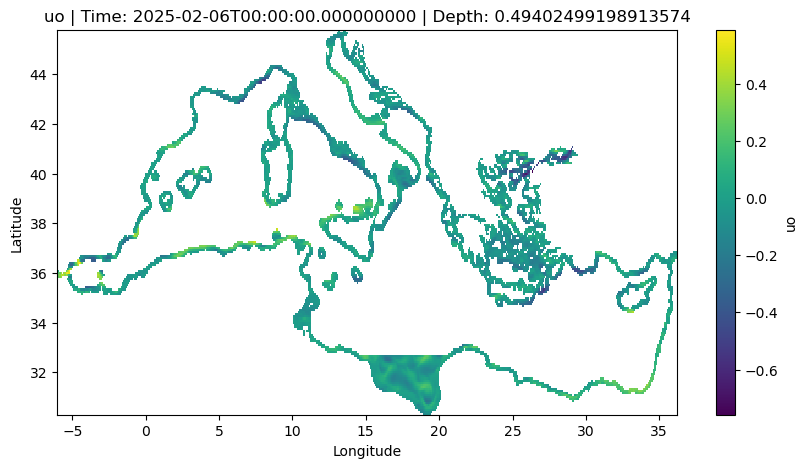

In [ ]:
# Select data
ds = dataset.isel(time=0, depth=0 if "depth" in dataset.dims else slice(None))

# Extract coordinates and values
lon, lat, uo = ds.longitude.values, ds.latitude.values, ds.uo.values

# Plot
plt.figure(figsize=(10, 5))
plt.pcolormesh(lon, lat, uo)
plt.colorbar(label="uo")
plt.xlabel("Longitude"), plt.ylabel("Latitude")
plt.title(f"uo | Time: {ds.time.values} | Depth: {ds.get('depth', 'Surface').values}")
plt.show()

## Conclusion

This notebook provides essential functions for handling geospatial data using polygon-based masking. 
It ensures that only relevant data within the selected region is processed.